In [1]:
import tensorflow as tf
import tensorflow_decision_forests as tfdf
import numpy as np
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import itertools
import pandas as pd
import tqdm

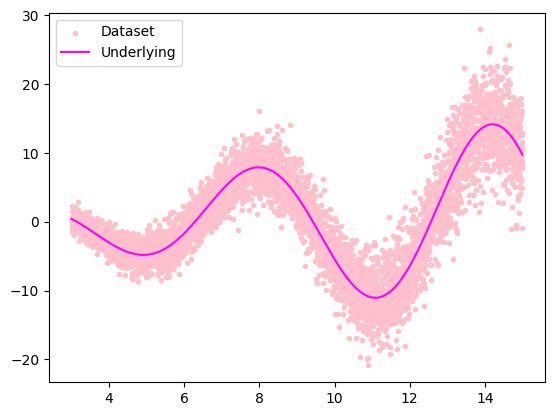

In [2]:
def f(x):
    return x * np.sin(x)

xMin = 3
xMax = 15
nSample = 5000

# input
x = np.linspace(xMin, xMax, nSample)
x_actual = np.linspace(xMin, xMax, nSample)
y_actual = f(x)

np.random.shuffle(x)

np.random.seed(17)
epsilon1 = np.random.normal(0.0, 0.3, nSample)
epsilon2 = np.random.normal(0.0, 0.3, nSample)

y = f(x) + epsilon1 + epsilon2 * x

plt.scatter(x, y, label = "Dataset", color = "pink", s = 9)
plt.plot(x_actual, y_actual, label = "Underlying", color = "magenta")
plt.legend()
plt.show()

X_train = x.reshape(-1, 1)
y_train = y.reshape(-1, 1)
X_test = np.arange(xMin, xMax+5, 0.01).reshape(-1, 1)

In [45]:
class GradientBoostedTreesEnsembleRegressor(tf.keras.Model):
    def __init__(self, n_trees=100, max_depth=3, n_estimators=100, sample_method='RANDOM'): 
        super(GradientBoostedTreesEnsembleRegressor, self).__init__()
        self.n_trees = n_trees
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.sample_method = sample_method
        self.estimators = []

    def build_estimator(self):
        model = tfdf.keras.GradientBoostedTreesModel(
            task=tfdf.keras.Task.REGRESSION,
            num_trees=self.n_trees,
            max_depth=np.random.randint(self.max_depth/2, self.max_depth+1),
            validation_ratio=0.1,
            sampling_method=self.sample_method,
            random_seed=self.seed # try to set this first. Maybe this is enough
        )
        return model
    
    # if not, the number of trees/depth different for each estimator

    def fit(self, X, y):
        num_data = X.shape[0]
        
        for seed in np.random.randint(0, 1000000, size=self.n_estimators):
            self.seed = int(seed) #passed to build_estimator
            
            # get the data index as a list
            indices = np.arange(num_data)
            indices = list(indices)
            
            # select a subset of indices for training
            train_estimator_size = int(len(indices)) 
            train_estimator_indices = np.random.choice(indices, size=train_estimator_size, replace=False)
            X_estimator_train = X[train_estimator_indices]
            y_estimator_train = y[train_estimator_indices]
            
            # building each estimator
            estimator = self.build_estimator()
            estimator.fit(X_estimator_train, y_estimator_train)
            
            self.estimators.append(estimator)

    def predict(self, X): # use all estimators
        predictions = []
        # sampled_estimators = np.random.choice(self.estimators, size=n_samples, replace=False)
        for estimator in self.estimators:
            estimator_predictions = []
            estimator_predictions.append(estimator.predict(X))
            estimator_predictions = tf.stack(estimator_predictions, axis=-1)
            predictions.append(tf.reduce_mean(estimator_predictions, axis=-1))
        predictions = tf.stack(predictions, axis=0)
        
        mean_prediction = tf.reduce_mean(predictions, axis=0)
        variance_prediction = tf.math.reduce_std(predictions, axis=0)
        return mean_prediction, variance_prediction



In [46]:
gbt_model = GradientBoostedTreesEnsembleRegressor(
    n_trees=50, 
    max_depth=5, 
    n_estimators=80, 
    # subportion=0.3, 
    sample_method='RANDOM'
)

In [47]:
gbt_model.fit(X_train, y_train)

Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmppivdgkqk as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.101249. Found 5000 examples.
Training model...
Model trained in 0:00:00.078881
Compiling model...


[WARNING 24-04-17 17:45:08.1989 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-17 17:45:08.1989 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-17 17:45:08.1989 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-17 17:45:08.3806 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmppivdgkqk/model/ with prefix 7437b2bdcefb45ce
[INFO 24-04-17 17:45:08.3822 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-04-17 17:45:08.3822 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpdnp_jwtl as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.086049. Found 5000 examples.
Training model...
Model trained in 0:00:00.032306
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpb_nzqzqb as temporary training directory
Reading training dataset...


[WARNING 24-04-17 17:45:08.4427 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-17 17:45:08.4427 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-17 17:45:08.4427 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-17 17:45:08.5635 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpdnp_jwtl/model/ with prefix fed6540030fb4057
[INFO 24-04-17 17:45:08.5638 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-17 17:45:08.6185 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-17 17:45:08.6185 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-17 17:45:08.6185 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.085773. Found 5000 examples.
Training model...
Model trained in 0:00:00.047314
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpbbj15sso as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.089312. Found 5000 examples.
Training model...
Model trained in 0:00:00.033644
Compiling model...


[INFO 24-04-17 17:45:08.7547 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpb_nzqzqb/model/ with prefix df8a3ef1f93c42aa
[INFO 24-04-17 17:45:08.7552 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-17 17:45:08.8095 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-17 17:45:08.8095 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-17 17:45:08.8095 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-17 17:45:08.9343 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpbbj15sso/model/ with prefix 5f9f4caa89ab427d
[INFO 24-04-17 17:45:08.9346 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpurzk8yfn as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.089358. Found 5000 examples.
Training model...
Model trained in 0:00:00.032720
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpihii008n as temporary training directory
Reading training dataset...


[WARNING 24-04-17 17:45:08.9885 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-17 17:45:08.9886 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-17 17:45:08.9886 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-17 17:45:09.1144 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpurzk8yfn/model/ with prefix 82e2bd6a73d941ef
[INFO 24-04-17 17:45:09.1147 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-17 17:45:09.1693 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-17 17:45:09.1693 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-17 17:45:09.1693 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.087470. Found 5000 examples.
Training model...
Model trained in 0:00:00.032373
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjl459t9o as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.085428. Found 5000 examples.
Training model...


[INFO 24-04-17 17:45:09.2911 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpihii008n/model/ with prefix aab82af478604ba8
[INFO 24-04-17 17:45:09.2915 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-17 17:45:09.3464 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-17 17:45:09.3464 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-17 17:45:09.3465 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.077877
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4rr8qevd as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.086059. Found 5000 examples.
Training model...


[INFO 24-04-17 17:45:09.5117 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjl459t9o/model/ with prefix df583147892848dc
[INFO 24-04-17 17:45:09.5132 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-17 17:45:09.5734 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-17 17:45:09.5734 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-17 17:45:09.5734 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.061731
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0tora_21 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.087938. Found 5000 examples.
Training model...
Model trained in 0:00:00.032646
Compiling model...


[INFO 24-04-17 17:45:09.7227 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4rr8qevd/model/ with prefix c0da0c4f45c14c74
[INFO 24-04-17 17:45:09.7236 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-17 17:45:09.7774 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-17 17:45:09.7774 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-17 17:45:09.7774 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-17 17:45:09.9014 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0tora_21/model/ with prefix b1953fd19d7b419d
[INFO 24-04-17 17:45:09.9017 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0owp11cr as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.087386. Found 5000 examples.
Training model...
Model trained in 0:00:00.047651
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpe1nv9lgr as temporary training directory
Reading training dataset...


[WARNING 24-04-17 17:45:09.9577 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-17 17:45:09.9577 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-17 17:45:09.9577 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-17 17:45:10.0947 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0owp11cr/model/ with prefix 3fb34ee4771844ff
[INFO 24-04-17 17:45:10.0953 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-17 17:45:10.1493 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-17 17:45:10.1493 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-17 17:45:10.1493 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.087725. Found 5000 examples.
Training model...
Model trained in 0:00:00.046996
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmps3gq39ph as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.086436. Found 5000 examples.
Training model...


[INFO 24-04-17 17:45:10.2869 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpe1nv9lgr/model/ with prefix b76e9cea9a044912
[INFO 24-04-17 17:45:10.2874 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-17 17:45:10.3431 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-17 17:45:10.3431 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-17 17:45:10.3432 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.076921
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmplb37rnvt as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.087186. Found 5000 examples.
Training model...
Model trained in 0:00:00.033403
Compiling model...


[INFO 24-04-17 17:45:10.5073 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmps3gq39ph/model/ with prefix b31f77fdefdd4db6
[INFO 24-04-17 17:45:10.5085 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-17 17:45:10.5637 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-17 17:45:10.5637 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-17 17:45:10.5637 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-17 17:45:10.6875 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmplb37rnvt/model/ with prefix 78f4484bee854add
[INFO 24-04-17 17:45:10.6879 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp41id9f2w as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.087649. Found 5000 examples.
Training model...
Model trained in 0:00:00.061527
Compiling model...
Model compiled.


[WARNING 24-04-17 17:45:10.7434 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-17 17:45:10.7434 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-17 17:45:10.7434 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-17 17:45:10.8943 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp41id9f2w/model/ with prefix 2d6eefece3364a6a
[INFO 24-04-17 17:45:10.8952 CEST kernel.cc:1061] Use fast generic engine


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp33j4icab as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.089609. Found 5000 examples.
Training model...
Model trained in 0:00:00.031943
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpgecoe3fm as temporary training directory
Reading training dataset...


[WARNING 24-04-17 17:45:10.9495 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-17 17:45:10.9495 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-17 17:45:10.9496 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-17 17:45:11.0745 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp33j4icab/model/ with prefix 5547efe37ffb4bf7
[INFO 24-04-17 17:45:11.0748 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-17 17:45:11.1282 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-17 17:45:11.1282 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-17 17:45:11.1282 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.087874. Found 5000 examples.
Training model...
Model trained in 0:00:00.061597
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp3i_hymk6 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.086481. Found 5000 examples.
Training model...


[INFO 24-04-17 17:45:11.2791 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpgecoe3fm/model/ with prefix 0d6fc425f05a4fd6
[INFO 24-04-17 17:45:11.2800 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-17 17:45:11.3361 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-17 17:45:11.3361 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-17 17:45:11.3361 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.078576
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0qrl8ux9 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.087259. Found 5000 examples.
Training model...
Model trained in 0:00:00.032464
Compiling model...


[INFO 24-04-17 17:45:11.5017 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp3i_hymk6/model/ with prefix 78609d83723f4734
[INFO 24-04-17 17:45:11.5032 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-17 17:45:11.5572 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-17 17:45:11.5572 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-17 17:45:11.5572 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-17 17:45:11.6788 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0qrl8ux9/model/ with prefix e380187cd57f4177
[INFO 24-04-17 17:45:11.6791 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0tbd6p0y as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.089276. Found 5000 examples.
Training model...
Model trained in 0:00:00.032779
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp13c1pa3l as temporary training directory
Reading training dataset...


[WARNING 24-04-17 17:45:11.7330 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-17 17:45:11.7330 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-17 17:45:11.7330 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-17 17:45:11.8584 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0tbd6p0y/model/ with prefix 1c93cdb222724654
[INFO 24-04-17 17:45:11.8587 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-17 17:45:11.9131 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-17 17:45:11.9131 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-17 17:45:11.9131 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.088141. Found 5000 examples.
Training model...
Model trained in 0:00:00.047182
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpq5ommqui as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.087408. Found 5000 examples.
Training model...


[INFO 24-04-17 17:45:12.0500 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp13c1pa3l/model/ with prefix b519c945140b4dc2
[INFO 24-04-17 17:45:12.0505 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-17 17:45:12.1051 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-17 17:45:12.1051 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-17 17:45:12.1051 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.077766
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpa1uiwyjg as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.089992. Found 5000 examples.
Training model...


[INFO 24-04-17 17:45:12.2723 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpq5ommqui/model/ with prefix e2d274a77fd04442
[INFO 24-04-17 17:45:12.2737 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-17 17:45:12.3324 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-17 17:45:12.3324 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-17 17:45:12.3324 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.078359
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5mas9u4e as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.088160. Found 5000 examples.
Training model...


[INFO 24-04-17 17:45:12.5018 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpa1uiwyjg/model/ with prefix 05ce096f9588403d
[INFO 24-04-17 17:45:12.5031 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-17 17:45:12.5607 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-17 17:45:12.5607 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-17 17:45:12.5608 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.061896
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjf5_h4ea as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.087033. Found 5000 examples.
Training model...
Model trained in 0:00:00.046748
Compiling model...


[INFO 24-04-17 17:45:12.7124 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5mas9u4e/model/ with prefix 7d6320053257441e
[INFO 24-04-17 17:45:12.7133 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-17 17:45:12.7689 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-17 17:45:12.7689 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-17 17:45:12.7690 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-17 17:45:12.9044 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjf5_h4ea/model/ with prefix 078b05b5d9014543
[INFO 24-04-17 17:45:12.9050 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1yax9bou as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.090390. Found 5000 examples.
Training model...
Model trained in 0:00:00.033216
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpe64mqlq9 as temporary training directory
Reading training dataset...


[WARNING 24-04-17 17:45:12.9595 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-17 17:45:12.9595 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-17 17:45:12.9595 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-17 17:45:13.0867 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1yax9bou/model/ with prefix 350934edfc3e4679
[INFO 24-04-17 17:45:13.0870 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-17 17:45:13.1421 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-17 17:45:13.1421 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-17 17:45:13.1421 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.087061. Found 5000 examples.
Training model...
Model trained in 0:00:00.078711
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5h93996w as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.085101. Found 5000 examples.
Training model...


[INFO 24-04-17 17:45:13.3088 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpe64mqlq9/model/ with prefix d289e8f0a6b9483c
[INFO 24-04-17 17:45:13.3103 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-17 17:45:13.3646 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-17 17:45:13.3646 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-17 17:45:13.3646 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.061766
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7dqmlb88 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.087008. Found 5000 examples.
Training model...


[INFO 24-04-17 17:45:13.5125 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5h93996w/model/ with prefix 252c48aebd1e45e1
[INFO 24-04-17 17:45:13.5135 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-17 17:45:13.5680 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-17 17:45:13.5681 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-17 17:45:13.5681 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.078295
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp55hphulo as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.085527. Found 5000 examples.
Training model...
Model trained in 0:00:00.046898
Compiling model...


[INFO 24-04-17 17:45:13.7343 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7dqmlb88/model/ with prefix da57c4f441964622
[INFO 24-04-17 17:45:13.7357 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-17 17:45:13.7906 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-17 17:45:13.7907 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-17 17:45:13.7907 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-17 17:45:13.9249 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp55hphulo/model/ with prefix deb3ab0f794a40bb
[INFO 24-04-17 17:45:13.9254 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpuwxt5pe9 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.089197. Found 5000 examples.
Training model...
Model trained in 0:00:00.034457
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2mmjwndq as temporary training directory
Reading training dataset...


[WARNING 24-04-17 17:45:13.9802 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-17 17:45:13.9802 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-17 17:45:13.9802 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-17 17:45:14.1070 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpuwxt5pe9/model/ with prefix f9225fb18e7e45a3
[INFO 24-04-17 17:45:14.1073 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-17 17:45:14.1612 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-17 17:45:14.1612 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-17 17:45:14.1613 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.086597. Found 5000 examples.
Training model...
Model trained in 0:00:00.033065
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2cw1ne5b as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.096477. Found 5000 examples.
Training model...


[INFO 24-04-17 17:45:14.2827 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2mmjwndq/model/ with prefix d498e1cb39904788
[INFO 24-04-17 17:45:14.2830 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-17 17:45:14.3378 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-17 17:45:14.3378 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-17 17:45:14.3378 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.079009
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpgxkv15qx as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.086294. Found 5000 examples.
Training model...
Model trained in 0:00:00.047171
Compiling model...


[INFO 24-04-17 17:45:14.5139 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2cw1ne5b/model/ with prefix f8155b4bc7944fee
[INFO 24-04-17 17:45:14.5155 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-17 17:45:14.5723 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-17 17:45:14.5723 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-17 17:45:14.5723 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-17 17:45:14.7076 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpgxkv15qx/model/ with prefix dd41e18af3874b21
[INFO 24-04-17 17:45:14.7082 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6sci9il6 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.086212. Found 5000 examples.
Training model...
Model trained in 0:00:00.078013
Compiling model...


[WARNING 24-04-17 17:45:14.7654 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-17 17:45:14.7654 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-17 17:45:14.7654 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-17 17:45:14.9306 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6sci9il6/model/ with prefix a52c60df4f6f4d40
[INFO 24-04-17 17:45:14.9322 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpiyj_3ddo as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.092541. Found 5000 examples.
Training model...
Model trained in 0:00:00.032882
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9xv60fic as temporary training directory
Reading training dataset...


[WARNING 24-04-17 17:45:14.9875 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-17 17:45:14.9875 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-17 17:45:14.9875 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-17 17:45:15.1151 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpiyj_3ddo/model/ with prefix cb75b91461e641e9
[INFO 24-04-17 17:45:15.1154 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-17 17:45:15.1684 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-17 17:45:15.1685 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-17 17:45:15.1685 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.089561. Found 5000 examples.
Training model...
Model trained in 0:00:00.033227
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpy4o65p89 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.087346. Found 5000 examples.
Training model...
Model trained in 0:00:00.033076
Compiling model...


[INFO 24-04-17 17:45:15.2944 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9xv60fic/model/ with prefix 00ae92a3160c402e
[INFO 24-04-17 17:45:15.2947 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-17 17:45:15.3480 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-17 17:45:15.3481 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-17 17:45:15.3481 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-17 17:45:15.4706 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpy4o65p89/model/ with prefix 64769590463443f2
[INFO 24-04-17 17:45:15.4709 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxky5uf88 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.087568. Found 5000 examples.
Training model...
Model trained in 0:00:00.077830
Compiling model...


[WARNING 24-04-17 17:45:15.5268 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-17 17:45:15.5268 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-17 17:45:15.5268 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-17 17:45:15.6936 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxky5uf88/model/ with prefix 963bc7f82e2743df
[INFO 24-04-17 17:45:15.6949 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_d4acjw8 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.084094. Found 5000 examples.
Training model...
Model trained in 0:00:00.033160
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprfose7w2 as temporary training directory
Reading training dataset...


[WARNING 24-04-17 17:45:15.7512 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-17 17:45:15.7512 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-17 17:45:15.7512 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-17 17:45:15.8710 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_d4acjw8/model/ with prefix a90c86ca18634b9f
[INFO 24-04-17 17:45:15.8713 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-17 17:45:15.9253 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-17 17:45:15.9253 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-17 17:45:15.9253 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.089123. Found 5000 examples.
Training model...
Model trained in 0:00:00.047944
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprvj5rc6h as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.087012. Found 5000 examples.
Training model...
Model trained in 0:00:00.033015
Compiling model...


[INFO 24-04-17 17:45:16.0640 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprfose7w2/model/ with prefix 7de78b3fd64847b7
[INFO 24-04-17 17:45:16.0646 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-17 17:45:16.1206 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-17 17:45:16.1206 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-17 17:45:16.1207 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-17 17:45:16.2440 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprvj5rc6h/model/ with prefix dbd5e3a979e84408
[INFO 24-04-17 17:45:16.2444 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzszch88q as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.087999. Found 5000 examples.
Training model...
Model trained in 0:00:00.047843
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8ioch7_a as temporary training directory
Reading training dataset...


[WARNING 24-04-17 17:45:16.3006 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-17 17:45:16.3006 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-17 17:45:16.3006 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-17 17:45:16.4385 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzszch88q/model/ with prefix 910da53631e947e1
[INFO 24-04-17 17:45:16.4391 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-17 17:45:16.4935 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-17 17:45:16.4936 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-17 17:45:16.4936 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.089582. Found 5000 examples.
Training model...
Model trained in 0:00:00.078520
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpddvwj6hr as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.087115. Found 5000 examples.
Training model...
Model trained in 0:00:00.032772
Compiling model...


[INFO 24-04-17 17:45:16.6638 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8ioch7_a/model/ with prefix bc37a5dcebab4217
[INFO 24-04-17 17:45:16.6650 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-17 17:45:16.7206 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-17 17:45:16.7206 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-17 17:45:16.7206 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-17 17:45:16.8426 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpddvwj6hr/model/ with prefix b016a4ef4ace455b
[INFO 24-04-17 17:45:16.8429 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7wfy6a9z as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.089383. Found 5000 examples.
Training model...
Model trained in 0:00:00.033532
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp313jk4ec as temporary training directory
Reading training dataset...


[WARNING 24-04-17 17:45:16.8984 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-17 17:45:16.8984 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-17 17:45:16.8984 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-17 17:45:17.0236 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7wfy6a9z/model/ with prefix 94c0ba971b594b6b
[INFO 24-04-17 17:45:17.0239 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-17 17:45:17.0788 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-17 17:45:17.0788 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-17 17:45:17.0788 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.088362. Found 5000 examples.
Training model...
Model trained in 0:00:00.078046
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpf_qrc2ie as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.085505. Found 5000 examples.
Training model...


[INFO 24-04-17 17:45:17.2474 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp313jk4ec/model/ with prefix 921fe794becf4446
[INFO 24-04-17 17:45:17.2489 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-17 17:45:17.3048 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-17 17:45:17.3048 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-17 17:45:17.3048 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.061956
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9vqkrvf1 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.090852. Found 5000 examples.
Training model...


[INFO 24-04-17 17:45:17.4537 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpf_qrc2ie/model/ with prefix 5f718c6dab6e48a7
[INFO 24-04-17 17:45:17.4546 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-17 17:45:17.5109 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-17 17:45:17.5110 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-17 17:45:17.5110 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.078742
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpidol6z_r as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.084878. Found 5000 examples.
Training model...


[INFO 24-04-17 17:45:17.6813 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9vqkrvf1/model/ with prefix 3b599f6534484a7d
[INFO 24-04-17 17:45:17.6828 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-17 17:45:17.7399 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-17 17:45:17.7399 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-17 17:45:17.7399 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.062351
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6pz9q821 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.086988. Found 5000 examples.
Training model...
Model trained in 0:00:00.033521
Compiling model...


[INFO 24-04-17 17:45:17.8884 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpidol6z_r/model/ with prefix 5ef605a1e4ff4bb6
[INFO 24-04-17 17:45:17.8893 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-17 17:45:17.9463 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-17 17:45:17.9463 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-17 17:45:17.9463 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-17 17:45:18.0689 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6pz9q821/model/ with prefix 87bd04d05d0d4b11
[INFO 24-04-17 17:45:18.0692 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpeeotyai8 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.089258. Found 5000 examples.
Training model...
Model trained in 0:00:00.032613
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpee_7zk5c as temporary training directory
Reading training dataset...


[WARNING 24-04-17 17:45:18.1257 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-17 17:45:18.1257 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-17 17:45:18.1257 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-17 17:45:18.2500 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpeeotyai8/model/ with prefix abcd497b7c034ae2
[INFO 24-04-17 17:45:18.2503 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-17 17:45:18.3026 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-17 17:45:18.3026 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-17 17:45:18.3026 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.089100. Found 5000 examples.
Training model...
Model trained in 0:00:00.047364
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7ksfueeq as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.088804. Found 5000 examples.
Training model...
Model trained in 0:00:00.033526
Compiling model...


[INFO 24-04-17 17:45:18.4418 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpee_7zk5c/model/ with prefix a70cc636cdde4683
[INFO 24-04-17 17:45:18.4424 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-04-17 17:45:18.4424 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-17 17:45:18.4952 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-17 17:45:18.4952 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-17 17:45:18.4952 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-17 17:45:18.6197 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7ksfueeq/model/ with prefix f87b25337a6e4d99
[INFO 24-04-17 17:45:18.6200 CEST kernel.cc:1061] Use fast ge

Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxk4nlag_ as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.087089. Found 5000 examples.
Training model...
Model trained in 0:00:00.034405
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpou0e44ea as temporary training directory
Reading training dataset...


[WARNING 24-04-17 17:45:18.6768 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-17 17:45:18.6769 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-17 17:45:18.6769 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-17 17:45:18.8007 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxk4nlag_/model/ with prefix 9837dff8b4f446ec
[INFO 24-04-17 17:45:18.8011 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-17 17:45:18.8553 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-17 17:45:18.8553 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-17 17:45:18.8553 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.088372. Found 5000 examples.
Training model...
Model trained in 0:00:00.062631
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpgw10hyjm as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.088933. Found 5000 examples.
Training model...


[INFO 24-04-17 17:45:19.0074 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpou0e44ea/model/ with prefix 0af49675772d49b0
[INFO 24-04-17 17:45:19.0083 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-17 17:45:19.0610 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-17 17:45:19.0610 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-17 17:45:19.0610 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.078301
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpyce54c7f as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.088506. Found 5000 examples.
Training model...


[INFO 24-04-17 17:45:19.2293 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpgw10hyjm/model/ with prefix 9c8912ab16d44fbc
[INFO 24-04-17 17:45:19.2306 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-17 17:45:19.2850 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-17 17:45:19.2850 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-17 17:45:19.2850 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.062532
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpbjg8zhwz as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.085025. Found 5000 examples.
Training model...
Model trained in 0:00:00.049365
Compiling model...


[INFO 24-04-17 17:45:19.4387 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpyce54c7f/model/ with prefix 8b7a2f470f5e4d47
[INFO 24-04-17 17:45:19.4397 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-17 17:45:19.4927 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-17 17:45:19.4927 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-17 17:45:19.4927 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-17 17:45:19.6286 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpbjg8zhwz/model/ with prefix b26e1d00f65847ab
[INFO 24-04-17 17:45:19.6291 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpn5vqvzjp as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.087807. Found 5000 examples.
Training model...
Model trained in 0:00:00.034612
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_fo3a3jh as temporary training directory
Reading training dataset...


[WARNING 24-04-17 17:45:19.6864 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-17 17:45:19.6864 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-17 17:45:19.6864 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-17 17:45:19.8112 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpn5vqvzjp/model/ with prefix 022e164e2a1e4309
[INFO 24-04-17 17:45:19.8115 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-17 17:45:19.8652 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-17 17:45:19.8652 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-17 17:45:19.8652 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.090460. Found 5000 examples.
Training model...
Model trained in 0:00:00.063601
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxz53kfpo as temporary training directory
Reading training dataset...


[INFO 24-04-17 17:45:20.0207 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_fo3a3jh/model/ with prefix 9ec8615a57f04c7e
[INFO 24-04-17 17:45:20.0217 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-17 17:45:20.0757 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-17 17:45:20.0757 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-17 17:45:20.0757 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.565877. Found 5000 examples.
Training model...
Model trained in 0:00:00.078957
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp269zegb_ as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.089143. Found 5000 examples.
Training model...


[INFO 24-04-17 17:45:20.7214 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxz53kfpo/model/ with prefix b0d89c72373a4955
[INFO 24-04-17 17:45:20.7229 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-17 17:45:20.7771 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-17 17:45:20.7771 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-17 17:45:20.7771 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.061521
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpv8i64yg1 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.089867. Found 5000 examples.
Training model...


[INFO 24-04-17 17:45:20.9315 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp269zegb_/model/ with prefix 2a21ca3c245b4e19
[INFO 24-04-17 17:45:20.9325 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-17 17:45:20.9874 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-17 17:45:20.9874 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-17 17:45:20.9874 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.080071
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp36mdh7ni as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.088403. Found 5000 examples.
Training model...


[INFO 24-04-17 17:45:21.1581 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpv8i64yg1/model/ with prefix cea2ba0d31ec404e
[INFO 24-04-17 17:45:21.1597 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-17 17:45:21.2163 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-17 17:45:21.2163 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-17 17:45:21.2163 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.076235
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpgeo7s0y4 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.090326. Found 5000 examples.
Training model...


[INFO 24-04-17 17:45:21.3831 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp36mdh7ni/model/ with prefix 6bc504601fed4d95
[INFO 24-04-17 17:45:21.3843 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-17 17:45:21.4413 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-17 17:45:21.4413 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-17 17:45:21.4413 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.061674
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6tzr9geb as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.088683. Found 5000 examples.
Training model...


[INFO 24-04-17 17:45:21.5946 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpgeo7s0y4/model/ with prefix e1048a1dafef4477
[INFO 24-04-17 17:45:21.5956 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-17 17:45:21.6551 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-17 17:45:21.6552 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-17 17:45:21.6552 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.061669
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpe9_2y0_n as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.088707. Found 5000 examples.
Training model...


[INFO 24-04-17 17:45:21.8069 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6tzr9geb/model/ with prefix c88bd2602204481e
[INFO 24-04-17 17:45:21.8079 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-17 17:45:21.8636 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-17 17:45:21.8636 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-17 17:45:21.8636 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.063583
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8o2mcmz8 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.093639. Found 5000 examples.
Training model...


[INFO 24-04-17 17:45:22.0170 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpe9_2y0_n/model/ with prefix 1c4eda774efe4e1c
[INFO 24-04-17 17:45:22.0180 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-17 17:45:22.0722 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-17 17:45:22.0722 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-17 17:45:22.0722 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.062725
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzrwaao0x as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.090225. Found 5000 examples.
Training model...


[INFO 24-04-17 17:45:22.2296 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8o2mcmz8/model/ with prefix e60e78f7db43455f
[INFO 24-04-17 17:45:22.2306 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-17 17:45:22.2870 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-17 17:45:22.2870 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-17 17:45:22.2870 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.077989
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmplv72ek3n as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.095734. Found 5000 examples.
Training model...
Model trained in 0:00:00.032246
Compiling model...


[INFO 24-04-17 17:45:22.4570 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzrwaao0x/model/ with prefix 6361ec1d9b744217
[INFO 24-04-17 17:45:22.4586 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-17 17:45:22.5169 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-17 17:45:22.5169 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-17 17:45:22.5169 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-17 17:45:22.6468 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmplv72ek3n/model/ with prefix 5a29b6ff7c2f441d
[INFO 24-04-17 17:45:22.6471 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmppyvg22z1 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.088728. Found 5000 examples.
Training model...
Model trained in 0:00:00.033647
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpnka0b6la as temporary training directory
Reading training dataset...


[WARNING 24-04-17 17:45:22.7050 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-17 17:45:22.7050 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-17 17:45:22.7051 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-17 17:45:22.8297 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmppyvg22z1/model/ with prefix 7e112c4e1ba047c2
[INFO 24-04-17 17:45:22.8301 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-17 17:45:22.8860 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-17 17:45:22.8860 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-17 17:45:22.8860 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.090408. Found 5000 examples.
Training model...
Model trained in 0:00:00.064323
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpnn51o6tb as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.091107. Found 5000 examples.
Training model...


[INFO 24-04-17 17:45:23.0422 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpnka0b6la/model/ with prefix 3112a7f7db7c4411
[INFO 24-04-17 17:45:23.0431 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-17 17:45:23.0991 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-17 17:45:23.0991 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-17 17:45:23.0991 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.080049
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpegv3thvw as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.091606. Found 5000 examples.
Training model...
Model trained in 0:00:00.047222


[INFO 24-04-17 17:45:23.2708 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpnn51o6tb/model/ with prefix 97d6f0e44b734aa6
[INFO 24-04-17 17:45:23.2723 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-17 17:45:23.3292 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-17 17:45:23.3292 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-17 17:45:23.3292 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-17 17:45:23.4708 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpegv3thvw/model/ with prefix 9fc57abc555d4404
[INFO 24-04-17 17:45:23.4714 CEST kernel.cc:1061] Use fast generic engine


Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpkzcaquhc as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.092525. Found 5000 examples.
Training model...
Model trained in 0:00:00.047751
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpylicm0ct as temporary training directory


[WARNING 24-04-17 17:45:23.5289 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-17 17:45:23.5290 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-17 17:45:23.5290 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-17 17:45:23.6713 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpkzcaquhc/model/ with prefix 2623ad607f7c4090
[INFO 24-04-17 17:45:23.6719 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-17 17:45:23.7284 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-17 17:45:23.7284 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-17 17:45:23.7284 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Reading training dataset...
Training dataset read in 0:00:00.091995. Found 5000 examples.
Training model...
Model trained in 0:00:00.061486
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpiwicuxst as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.089602. Found 5000 examples.
Training model...
Model trained in 0:00:00.047156
Compiling model...


[INFO 24-04-17 17:45:23.8839 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpylicm0ct/model/ with prefix f033a6675d724b91
[INFO 24-04-17 17:45:23.8848 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-17 17:45:23.9409 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-17 17:45:23.9409 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-17 17:45:23.9409 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-17 17:45:24.0796 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpiwicuxst/model/ with prefix 4a553ede354345f6
[INFO 24-04-17 17:45:24.0801 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4lvv1nq9 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.090165. Found 5000 examples.
Training model...
Model trained in 0:00:00.033945
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpwj84at3o as temporary training directory
Reading training dataset...


[WARNING 24-04-17 17:45:24.1375 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-17 17:45:24.1375 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-17 17:45:24.1375 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-17 17:45:24.2636 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4lvv1nq9/model/ with prefix cb853439881642c1
[INFO 24-04-17 17:45:24.2639 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-17 17:45:24.3194 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-17 17:45:24.3194 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-17 17:45:24.3194 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.091904. Found 5000 examples.
Training model...
Model trained in 0:00:00.048717
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_csik6y_ as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.095474. Found 5000 examples.
Training model...
Model trained in 0:00:00.033766
Compiling model...


[INFO 24-04-17 17:45:24.4617 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpwj84at3o/model/ with prefix a7870cb0c4184b81
[INFO 24-04-17 17:45:24.4623 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-17 17:45:24.5157 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-17 17:45:24.5157 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-17 17:45:24.5157 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-17 17:45:24.6485 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_csik6y_/model/ with prefix a17f57e6341f4438
[INFO 24-04-17 17:45:24.6488 CEST kernel.cc:1061] Use fast generic engine


Model compiled.


In [49]:
mean_prediction, variance_prediction = gbt_model.predict(X_test) #, n_runs=80, n_samples=50

54/54 [==============================] - 0s 388us/step


In [50]:
print(mean_prediction.shape)
print(variance_prediction.shape)
print(variance_prediction)

(1700, 1)
(1700, 1)
tf.Tensor(
[[0.3917589 ]
 [0.3917589 ]
 [0.36132073]
 ...
 [0.6717641 ]
 [0.6717641 ]
 [0.6717641 ]], shape=(1700, 1), dtype=float32)


In [51]:
xlim = (xMin,xMax+5)
x_test = X_test.flatten()
y_pred = mean_prediction.numpy().flatten()
uncertainties = variance_prediction.numpy().flatten()

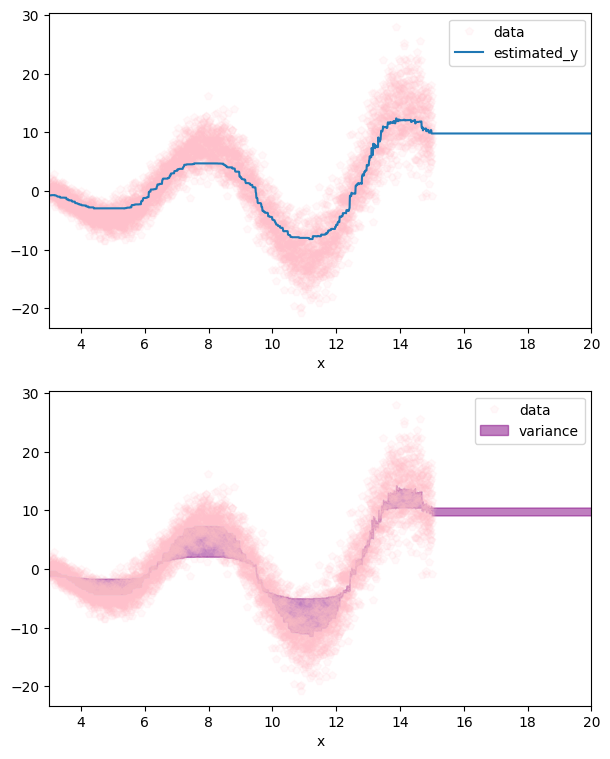

In [52]:

fig = plt.figure(figsize=(7,9))

ax = fig.add_subplot(2,1,1)
ax.plot(X_train,y_train,"p",alpha=0.1,c="pink",label="data")
ax.plot(x_test,y_pred,label="estimated_y")
ax.set_xlabel("x")
ax.set_xlim(*xlim)
ax.legend()

ax = fig.add_subplot(2,1,2)
ax.plot(X_train,y_train,"p",alpha=0.1,label="data",c="pink")
# ax.plot(x_test,y_pred,label="estimated_y", c="skyblue")
ax.fill_between(x_test, y_pred - uncertainties, y_pred + uncertainties, alpha = 0.5, label="variance", color="purple")
ax.set_xlabel("x")
ax.set_xlim(*xlim)
ax.legend()
plt.show()